In [10]:
%matplotlib inline

FOLDS_SEED = 113


import numpy as np
from itertools import *
from math import *
import cv2
import util
import scr
import argparse
import os
import pickle
import jsrt

from skimage import draw
from skimage.segmentation import find_boundaries
from sklearn.cross_validation import StratifiedKFold

from collections import OrderedDict
import menpo.io as mio
from menpo.image import Image
from menpo.landmark import *
from menpo.shape import *
from matplotlib import pyplot as plt

def normalize_for_amm(image):
    mean = np.mean(image)
    std = np.std(image)
    image = (image - mean)/std
    min_ = np.min(image)
    max_ = np.max(image)
    image = (image - min_)/(max_ - min_ + 1e-7)
    image = image.reshape((1,) + image.shape)
    return image

def prepare_data_for_aam(images, landmarks):
    images_aam = []
    for i in range(len(images)):
        images[i] = normalize_for_amm(images[i])
        images_aam.append(Image(images[i]))
        lmx = landmarks[0][i].T[0]
        lmy = landmarks[0][i].T[1]
        num_points = len(landmarks[0])
        rmx = landmarks[1][i].T[0]
        rmy = landmarks[1][i].T[1]
        pc = PointCloud(points=np.vstack((np.array([lmy, lmx]).T, np.array([rmy, rmx]).T))/2)
        lg = LandmarkGroup.init_from_indices_mapping(pc, 
            OrderedDict({'left':range(len(landmarks[0][i])), 'right':range(len(landmarks[0][i]), len(landmarks[0][i]) + len(landmarks[1][i]))}))
        lm = LandmarkManager()
        lm.setdefault('left', lg)
        images_aam[-1].landmarks = lm
    return images_aam

def create_mask_from_landmarks(landmarks, mask_shape=(512, 512)):
    landmarks = (landmarks/2).astype(np.int)
    mask = np.full(shape=mask_shape, fill_value=False, dtype=np.bool)

    rr, cc = draw.polygon(landmarks.T[1], landmarks.T[0])
    mask[rr, cc] = True

    return mask

class ActiveAppearanceModel:
    def __init__(self):
        self.mean_shape = None 
        self.image_shape = None
        self.fitter = None

    def fit(self, images, landmarks):
        num_samples = len(landmarks[0])
        
        aam_images = prepare_data_for_aam(images, landmarks)
        aam = PatchAAM(aam_images, group=None, patch_shape=[(15, 15), (23, 23)],
                         diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
                         max_shape_components=20, max_appearance_components=150,
                         verbose=True)

        self.fitter = LucasKanadeAAMFitter(aam,
                                  lk_algorithm_cls=WibergInverseCompositional,
                                  n_shape=[5, 20], n_appearance=[30, 150])
        
        pc = []
        for img in aam_images:
            pc.append(img.landmarks[None].lms)
            
        self.mean_shape = mean_pointcloud(pc)
        self.image_shape = images[0].shape

        fitting_results = []
        for img in aam_images[:10]:
            fr = self.fitter.fit_from_shape(img, self.mean_shape, gt_shape=img.landmarks[None].lms) 
            print(fr)
            fitting_results.append(fr)
            
        visualize_fitting_result(fitting_results)
        

    def transform(self, images):
        if len(images[0].shape) == 2:
            num_samples = len(images)
            masks = np.zeros(shape=(num_samples,) + self.image_shape)
            for i in range(num_samples):
                image_aam = Image(normalize_for_amm(images[i]))
                fr = self.fitter.fit_from_shape(image_aam, self.mean_shape) 
                pred_landmarks = fr.final_shape.as_vector()
                print("shape {}".format(type(pred_landmarks)))
                print("fit output shape {}".format(pred_landmarks.shape))
                masks[i] = create_mask_from_landmarks(pred_landmarks)
            return masks
        
        elif len(images.shape) == 2:
            images = Image(normalize_for_amm(images))
            fr = self.fitter.fit_from_shape(images, self.mean_shape) 
            pred_landmarks = fr.final_shape.as_vector()
            print("fit output shape {}".format(pred_landmarks.shape))
            return create_mask_from_landmarks(pred_landmarks)

set_name = 'jsrt140'
paths, locs, rads, subs, sizes, kinds = jsrt.jsrt(set=set_name)
images = jsrt.images_from_paths(paths, dsize=(512, 512))
landmarks = scr.load_data(set=set_name)

assert len(landmarks[0]) == len(images)


landmarks 1-d 2, 2-n-d (233, 44, 2)


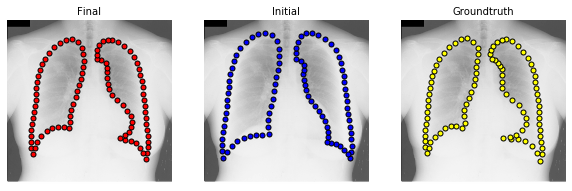

In [11]:
from menpofit.aam import HolisticAAM, PatchAAM
from menpo.feature import *
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
from menpowidgets import visualize_fitting_result


folds = StratifiedKFold(subs, n_folds=10, shuffle=True, random_state=FOLDS_SEED)

i = 1
for tr_idx, te_idx in folds:   
    print "Landmarks shape {}".format(landmarks[0].shape)
    model = ActiveAppearanceModel()
    model.fit(images[tr_idx], [landmarks[0][tr_idx], landmarks[1][tr_idx]])
    break;

    masks = model.transform(images[te_idx])
    for mask in masks:
        plt.imshow(mask)
        plt.show()
        
    break;
    i += 1

In [ ]:
0.9 variance
Initial error: 0.0788
Final error: 0.0167
Fitting result of 94 landmark points.
Initial error: 0.1436
Final error: 0.0110
Fitting result of 94 landmark points.
Initial error: 0.0687
Final error: 0.0090
Fitting result of 94 landmark points.
Initial error: 0.1107
Final error: 0.0166
Fitting result of 94 landmark points.
Initial error: 0.0633
Final error: 0.0090
Fitting result of 94 landmark points.
Initial error: 0.0418
Final error: 0.0073
Fitting result of 94 landmark points.
Initial error: 0.0713
Final error: 0.0101
Fitting result of 94 landmark points.
Initial error: 0.0411
Final error: 0.0099
Fitting result of 94 landmark points.
Initial error: 0.0537
Final error: 0.0129
    
    
notebook config
\Initial error: 0.0788
Final error: 0.0068
Fitting result of 94 landmark points.
Initial error: 0.1436
Final error: 0.0071
Fitting result of 94 landmark points.
Initial error: 0.0687
Final error: 0.0054
Fitting result of 94 landmark points.
Initial error: 0.1107
Final error: 0.0051
Fitting result of 94 landmark points.
Initial error: 0.0633
Final error: 0.0069
Fitting result of 94 landmark points.
Initial error: 0.0418
Final error: 0.0053
Fitting result of 94 landmark points.
Initial error: 0.0713
Final error: 0.0057
Fitting result of 94 landmark points.
Initial error: 0.0411
Final error: 0.0076
Fitting result of 94 landmark points.
Initial error: 0.0537
Final error: 0.0119